In [6]:
import os
import json
import random

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import collections  as mc
from sklearn.cluster import KMeans
from keras.models import Sequential
from keras import layers

random.seed(1337)
np.random.seed(451)

In [7]:
def data_from_file(file):
    # Read json sequence data
    with open(file) as f:
        data = np.array(json.load(f))
    return data

In [8]:
# Hyperparameters
# ======================================================================
num_classes = 10         # Amount of k-means clusters & classes for NN
batch_size = 128         # How many samples are in a batch
seq_len = 10             # How long is the sequence / sample to train
data_split = 0.2         # Percentage for validation & testing set
shuffle = False          # Randomly shuffle training data

num_layers = 1           # Number of hidden LSTM layers
num_units = 256          # Number of units per LSTM layer
epochs = 10              # How many epochs to train

# Data sources
# ======================================================================
# data = data_from_file('./files/json/sequence.json')
# data = data_from_file('./files/json/sequence2.json')
data = data_from_file('./files/json/sequence3.json')

In [28]:
def k_means_encode_data(data, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(data[:,0])
    new_data = []
    for column in data:
        new_column = []
        for point in column:
            predicted = kmeans.predict([point])[0]
            new_column.append(predicted)
        new_data.append(new_column)
    return np.array(new_data), kmeans

def k_means_decode_data(data, kmeans):
    new_data = []
    for column in data:
        new_column = []
        for cluster_index in column:
            center = kmeans.cluster_centers_[cluster_index]
            new_column.append(center)
        new_data.append(new_column)
    return np.array(new_data)

# Simplify the PCA space with k-means clustering
encoded_data, kmeans = k_means_encode_data(data, num_classes)
decoded_data_test = k_means_decode_data(encoded_data, kmeans)

print('Number of classes:', num_classes)
print('Data size:', len(data))

Number of classes: 10
Data size: 35999


In [29]:
# Show an example on how the data looks now
test_index = 0
print('Original:', data[test_index])
print('Encoded:', encoded_data[test_index])print('Decoded:', decoded_data_test[test_index])

Original: [[0.46392624 0.26740089]
 [0.44737112 0.24449598]]
Encoded: [4 4]
Decoded: [[0.45057369 0.26800009]
 [0.45057369 0.26800009]]


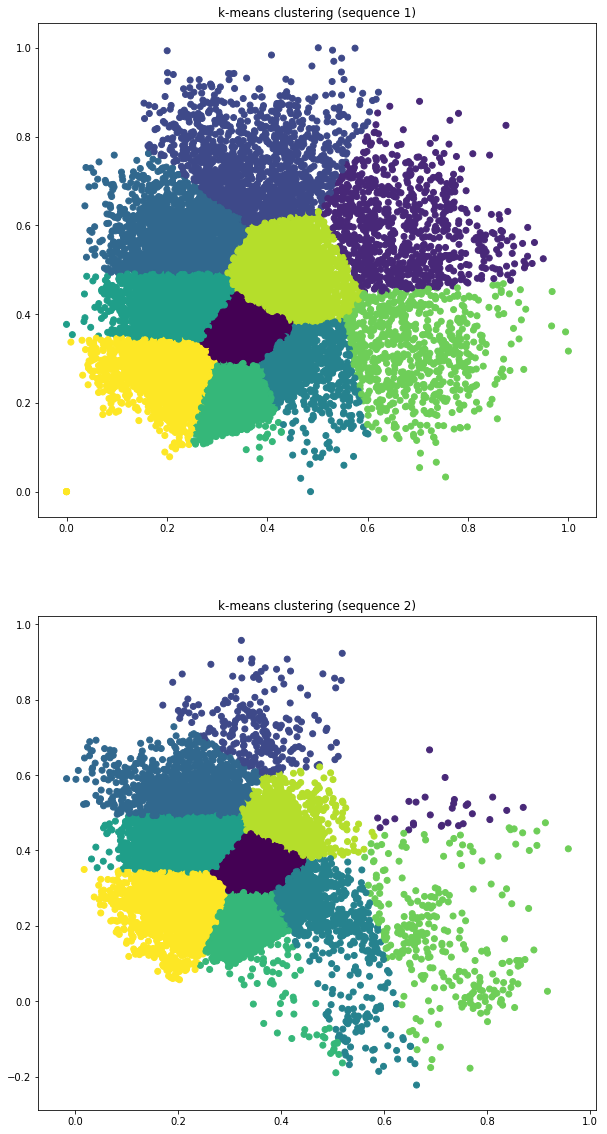

In [45]:
# Plot kmeans clusters
plt.figure(figsize=(10, 20))

plt.subplot(2, 1, 1, title="k-means clustering (sequence 1)")
plt.scatter(data[:, 0, 0],
           data[:, 0, 1],
           c=kmeans.predict(data[:, 0]))

plt.subplot(2, 1, 2, title="k-means clustering (sequence 2)")
plt.scatter(data[:, 1, 0],
           data[:, 1, 1],
           c=kmeans.predict(data[:, 1]))

plt.show()

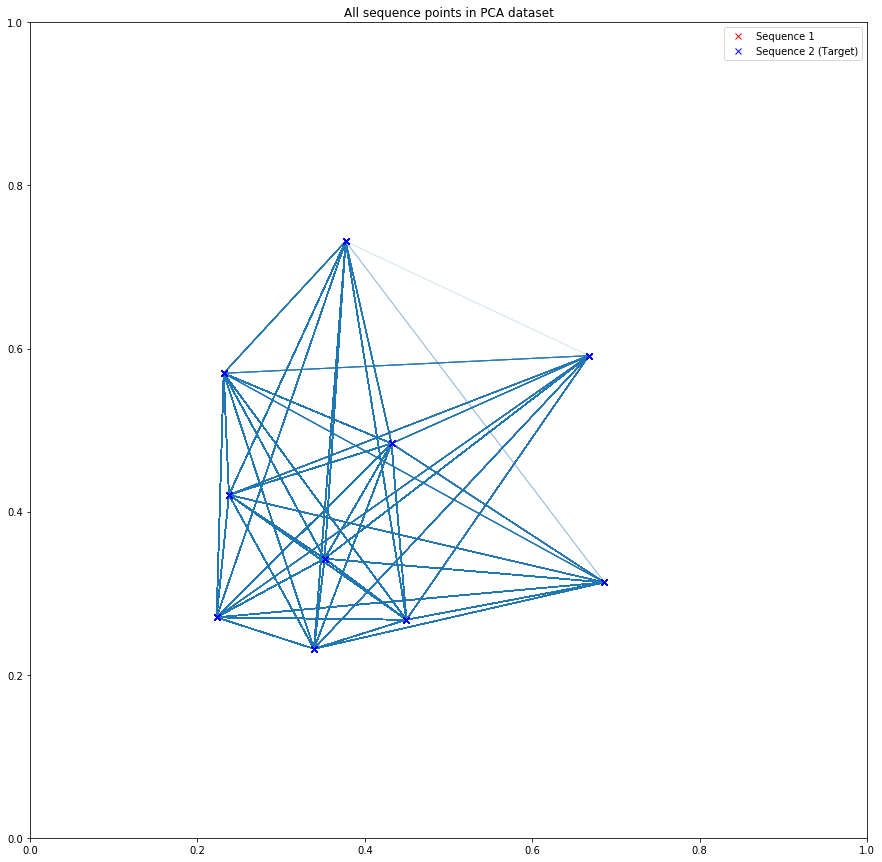

In [15]:
# Plot PCA coordinate data
plot_data = decoded_data_test

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title('All sequence points in PCA dataset')
ax.axis([0.0, 1.0, 0.0, 1.0])

ax.plot(plot_data[:,0,0], plot_data[:,0,1], 'rx', label='Sequence 1')
ax.plot(plot_data[:,1,0], plot_data[:,1,1], 'bx', label='Sequence 2 (Target)')

lines = [[p[0], p[1]] for p in plot_data]
lc = mc.LineCollection(lines, linewidths=1, alpha=0.1)
ax.add_collection(lc)

ax.legend()
plt.show()

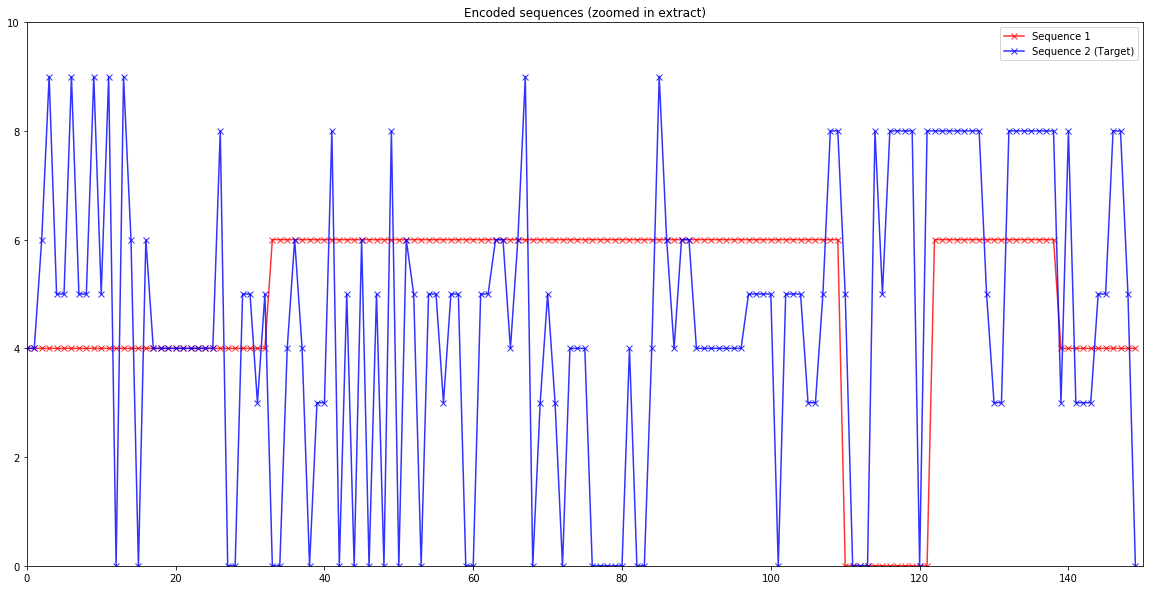

In [55]:
# Plot sequence data
sequence1 = encoded_data[:, 0][:150]
sequence2 = encoded_data[:, 1][:150]

plt.figure(figsize=(20, 10))

plt.plot(range(len(sequence1)), sequence1, color='red', marker='x', label='Sequence 1', alpha=0.8)
plt.plot(range(len(sequence2)), sequence2, color='blue', marker='x', label='Sequence 2 (Target)', alpha=0.8)

plt.legend(frameon=True)
plt.title('Encoded sequences (zoomed in, extract)')
plt.axis([0, max(len(sequence1), len(sequence2)), 0, num_classes])

plt.show()

In [56]:
def generator(data, seq_len, min_index, max_index, shuffle=False):
    i = min_index
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows), seq_len), dtype='int32')
        targets = np.zeros((len(rows)), dtype='int32')
        for j, _ in enumerate(rows):
            indices = range(rows[j], rows[j] + seq_len)
            if indices[-1] < max_index:
                samples[j] = data[:, 0][indices]
                targets[j] = data[:, 1][indices][-1]
        yield samples, targets

In [57]:
# Split in 3 sets for training, validation and testing
validation_steps = round((data_split / 2) * len(data))

train_max = len(data) - (validation_steps * 2)
val_min = train_max + 1
val_max = train_max + validation_steps + 1
test_min = train_max + validation_steps + 2
test_max = len(data) - 1

training_steps = test_max - test_min

train_gen = generator(encoded_data,
                      seq_len=seq_len,
                      min_index=0,
                      max_index=train_max,
                      shuffle=shuffle)

val_gen = generator(encoded_data,
                    seq_len=seq_len,
                    min_index=val_min,
                    max_index=val_max)

test_gen = generator(encoded_data,
                     seq_len=seq_len,
                     min_index=test_min,
                     max_index=test_max)

steps_per_epoch = train_max // batch_size

print('Batch size:', batch_size)
print('Steps per epoch:', steps_per_epoch)

print('\nSplit for validation & test @ {0:.2f}%'.format(data_split * 100))
print('Training set:', (0, train_max))
print('Validation set:', (val_min, val_max))
print('Test set:', (test_min, test_max))

samples, targets = next(train_gen)
print(samples)
print(samples.shape)

Batch size: 128
Steps per epoch: 224

Split for validation & test @ 20.00%
Training set: (0, 28799)
Validation set: (28800, 32400)
Test set: (32401, 35998)
[[4 4 4 ... 4 4 4]
 [4 4 4 ... 4 4 4]
 [4 4 4 ... 4 4 4]
 ...
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]]
(128, 10)


In [58]:
model = Sequential()
model.add(layers.Embedding(input_dim=num_classes,
                           output_dim=num_units,
                           input_length=seq_len))
for n in range(num_layers - 1):
    model.add(layers.LSTM(num_units, return_sequences=True))
model.add(layers.LSTM(num_units))
model.add(layers.Dense(num_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10, 256)           2560      
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 530,442
Trainable params: 530,442
Non-trainable params: 0
_________________________________________________________________


In [59]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=steps_per_epoch,
                              epochs=epochs,
                              validation_data=val_gen,
                              validation_steps=validation_steps)

Epoch 1/10
224/224 [==============================] - 139s 621ms/step - loss: 1.9632 - acc: 0.2499 - val_loss: 1.7707 - val_acc: 0.2366
Epoch 2/10
224/224 [==============================] - 134s 596ms/step - loss: 1.9108 - acc: 0.2360 - val_loss: 1.7745 - val_acc: 0.2175
Epoch 3/10
224/224 [==============================] - 134s 599ms/step - loss: 1.9063 - acc: 0.2415 - val_loss: 1.7806 - val_acc: 0.2174
Epoch 4/10
224/224 [==============================] - 134s 598ms/step - loss: 1.9045 - acc: 0.2406 - val_loss: 1.7809 - val_acc: 0.2173
Epoch 5/10
224/224 [==============================] - 138s 616ms/step - loss: 1.9025 - acc: 0.2391 - val_loss: 1.7823 - val_acc: 0.2173
Epoch 6/10
224/224 [==============================] - 128s 572ms/step - loss: 1.9004 - acc: 0.2374 - val_loss: 1.7833 - val_acc: 0.2173
Epoch 7/10
224/224 [==============================] - 128s 571ms/step - loss: 1.8984 - acc: 0.2404 - val_loss: 1.7843 - val_acc: 0.2175
Epoch 8/10
224/224 [============================

In [ ]:
# Plot validation and training loss
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

In [ ]:
# Calculate scores with training set
temperature = 1           # Temperature for reweighting the distribution
max_dist = .25            # Maximum distance for max. score penalty

def reweight_distribution(original_distribution, temperature):
    distribution = np.log(original_distribution) / temperature
    distribution = np.exp(distribution)
    return distribution / np.sum(distribution)

scores = []
points = []
points_targets = []

for i in range((training_steps // batch_size)):
    # Predict point from model
    samples, targets = next(test_gen)
    results = model.predict(samples)
    
    for j, result in enumerate(results):
        # Reweight the softmax distribution
        result_reweighted = reweight_distribution(result, temperature)
        result_value = np.argmax(result_reweighted)
        
        # Decode data
        position = decode_data([[result_value]], grid_size).flatten()
        position_target = decode_data([[targets[j]]], grid_size).flatten()
        points.append(position)
        points_targets.append(position_target)

        # Calculate distance between prediction and actual test target
        dist = max_dist - min(max_dist, np.linalg.norm(position - position_target))
        scores.append(0.0 if dist == 0.0 else dist / max_dist)
        
points = np.array(points)
points_targets = np.array(points_targets)
score = np.average(scores)

print('Score: {0:.2f}%'.format(score * 100))

In [ ]:
# Plot model prediction results
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_title('Test targets and model predictions')
ax.axis([0.0, 1.0, 0.0, 1.0])

lines = [[points_targets[i], points[i]] for i in range(len(points))]
lc = mc.LineCollection(lines, linewidths=1)
lc.set_array(np.array(scores))
lc.set_clim(0.0, 1.0)
lc.set_cmap('plasma')
ax.add_collection(lc)

axcb = fig.colorbar(lc)
axcb.set_label('Score')

ax.plot(points_targets[:,0], points_targets[:,1], 'rx', label='Target')

colors = np.array([[s, 0, 0] for s in scores])
ax.scatter(points[:,0], points[:,1], label='Result', color='r', marker='^')

ax.legend()
plt.show()